# What's in this Notebook?
Now that I've settled on a random forest model (as the happy medium of accuracy and interpretability), I want to know what the model is getting wrong and maybe see if I can leverage that info to improve my model.

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, auc, classification_report, roc_curve
from eval_helpers import *
import pickle
import spotipy 
import config
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# import the data
with open('model_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [141]:
# drop the two songs with null values 
# separate the X and y variables 
data.drop(['4cCio6f3kmmufjWVsEfMu0', '6AyIvQ7Npap06gZzsHU3Hy'], inplace=True)
X = data.drop('ballet', axis=1)
y = data['ballet']

## Tune the model _one last time_
Just to see if we can get it ever so slightly better.

classification report: 

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       215
           1       0.81      0.81      0.81       210

   micro avg       0.82      0.82      0.82       425
   macro avg       0.82      0.82      0.82       425
weighted avg       0.82      0.82      0.82       425

ROC AUC: 0.8164451827242525
Accuracy score: 0.8164705882352942


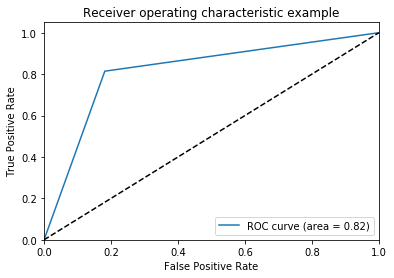

Confusion matrix, without normalization
[[176  39]
 [ 39 171]]
Normalized confusion matrix
[[0.81860465 0.18139535]
 [0.18571429 0.81428571]]


<Figure size 432x288 with 0 Axes>

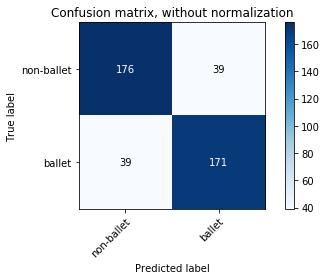

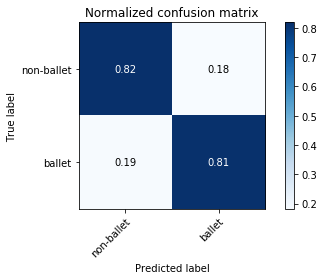

<Figure size 432x288 with 0 Axes>

In [5]:
# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

rfc = RandomForestClassifier(max_depth=10, max_features=15, 
                             min_samples_leaf=10, min_samples_split=10,
                            n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluation(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
plt_cm(y_test, y_pred)

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distrib = {"max_depth": randint(1, 50),
              "max_features": randint(1, 20),
                 "min_samples_leaf": randint(2, 1000),
              "min_samples_split": randint(2, 1000),
                 "n_estimators": randint(10,1000)
                }

clf = RandomizedSearchCV(RandomForestClassifier(), param_distrib, n_iter=2000)

In [39]:
clf.fit(X, y)
clf.best_params_

/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 26,
 'max_features': 19,
 'min_samples_leaf': 9,
 'min_samples_split': 130,
 'n_estimators': 247}

In [40]:
print(clf.best_params_)
random_clf = clf.best_estimator_
random_clf.fit(X_train, y_train)

{'max_depth': 26, 'max_features': 19, 'min_samples_leaf': 9, 'min_samples_split': 130, 'n_estimators': 247}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=130,
            min_weight_fraction_leaf=0.0, n_estimators=247, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [141]:
y_pred = random_clf.predict(X_test)
evaluation(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
plt_cm(y_test, y_pred)

classification report: 



TypeError: Expected sequence or array-like, got estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=130,
            min_weight_fraction_leaf=0.0, n_estimators=247, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Another one of the randomized search cv results:

In [36]:
print(clf.best_params_)
random_clf = clf.best_estimator_
random_clf.fit(X_train, y_train)

{'max_depth': 21, 'max_features': 16, 'min_samples_leaf': 48, 'min_samples_split': 61}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=48, min_samples_split=61,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

classification report: 

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       215
           1       0.82      0.80      0.81       210

   micro avg       0.82      0.82      0.82       425
   macro avg       0.82      0.82      0.82       425
weighted avg       0.82      0.82      0.82       425

ROC AUC: 0.8186600221483943
Accuracy score: 0.8188235294117647


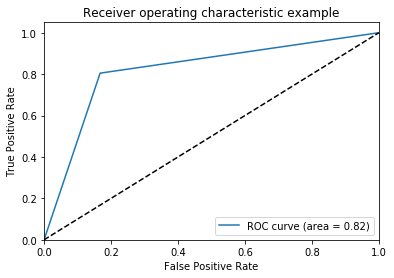

Confusion matrix, without normalization
[[179  36]
 [ 41 169]]
Normalized confusion matrix
[[0.83255814 0.16744186]
 [0.1952381  0.8047619 ]]


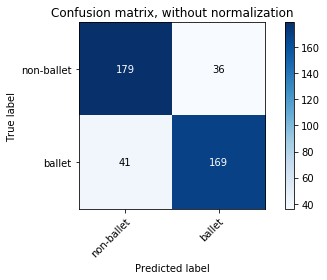

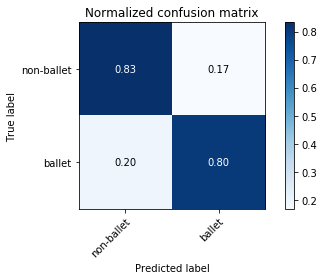

In [34]:
y_pred = random_clf.predict(X_test)
evaluation(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
plt_cm(y_test, y_pred)

I'll choose the first of the two models displayed above, because if I have to choose, I'd rather it classify more ballets correctly, since I want to uncover what's special about ballets. Now I'll look at the feature importance for the chosen model!

In [6]:
# final model!
forest = RandomForestClassifier(max_depth=26, max_features=19,
                               min_samples_leaf=9, min_samples_split=130, 
                                n_estimators=247)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [14]:
evaluation(y_test,y_pred)

classification report: 

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       215
           1       0.81      0.83      0.82       210

   micro avg       0.82      0.82      0.82       425
   macro avg       0.82      0.82      0.82       425
weighted avg       0.82      0.82      0.82       425

ROC AUC: 0.818936877076412
Accuracy score: 0.8188235294117647


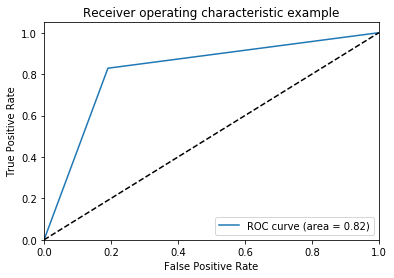

In [12]:
plot_roc_curve(y_test,y_pred, 'rf_roccurve')

Confusion matrix, without normalization
[[174  41]
 [ 36 174]]
Normalized confusion matrix
[[0.80930233 0.19069767]
 [0.17142857 0.82857143]]


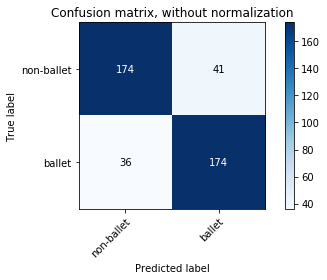

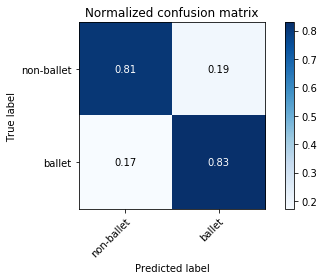

In [13]:
plt_cm(y_test,y_pred, 'rf_cm')

## Feature Importance

Feature ranking:
1. feature 2 (0.643889)
aka duration_ms
2. feature 14 (0.114576)
aka no_sections
3. feature 13 (0.087662)
aka no_segments
4. feature 0 (0.077765)
aka acousticness
5. feature 24 (0.015979)
aka mean_pitch
6. feature 22 (0.013807)
aka no_unique_pitches
7. feature 12 (0.010490)
aka valence
8. feature 17 (0.006090)
aka sec_loudness_range
9. feature 23 (0.004545)
aka no_unique_timbres
10. feature 6 (0.004032)
aka liveness
11. feature 19 (0.003435)
aka sec_tempo_range
12. feature 4 (0.002537)
aka instrumentalness
13. feature 10 (0.002305)
aka tempo
14. feature 3 (0.002155)
aka energy
15. feature 1 (0.002146)
aka danceability
16. feature 9 (0.002144)
aka speechiness
17. feature 21 (0.001621)
aka sec_time_signature_range
18. feature 16 (0.001523)
aka seg_duration_range
19. feature 15 (0.001425)
aka sec_duration_range
20. feature 7 (0.000953)
aka loudness
21. feature 18 (0.000514)
aka sec_key_range
22. feature 5 (0.000253)
aka key
23. feature 8 (0.000152)
aka mode
24. feature 20

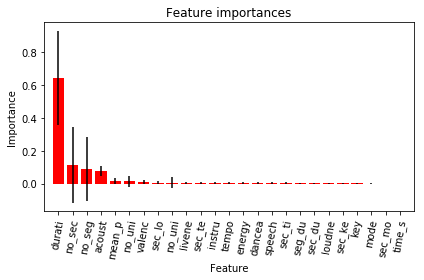

In [27]:
# code taken from sklearn documentation
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

x_labels = []
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print('aka', X.columns[indices[f]])
    x_labels.append(X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [x[:6] for x in x_labels], rotation=80)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance', dpi=200)
plt.show()

In [9]:
X.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'no_segments',
       'no_sections', 'sec_duration_range', 'seg_duration_range',
       'sec_loudness_range', 'sec_key_range', 'sec_tempo_range',
       'sec_mode_range', 'sec_time_signature_range', 'no_unique_pitches',
       'no_unique_timbres', 'mean_pitch'],
      dtype='object')

Found on [medium](https://medium.com/@srnghn/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3): "Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature."

## What songs are being misclassified?

In [29]:
# predict on all of the data
y_pred = forest.predict(data[X.columns])

In [30]:
# songs that are misclassified
misclassified_ids = ['spotify:track:'+id for id in list(data[data['ballet'] != y_pred].index)]

In [31]:
# setting up spotify so we can get info on misclassified songs
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id=config.client_id, 
                                                          client_secret=
                                                          config.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [32]:
# make a list of info on misclassified songs - a tuple with the song info and the uri 
# so we can map the info back to a row in the table
import time
misclassified_song_info = []
for song in misclassified_ids:
    misclassified_song_info.append((sp.track(song), song))
    time.sleep(.25)

In [33]:
# TO GET GENRES: webscrape last.fm top tags
import requests
from bs4 import BeautifulSoup

# list of tuples with song name, song artist, and spotify URI
songs = [(song[0]['name'], song[0]['artists'][0]['name'], song[1]) for song in misclassified_song_info]
song_tags = {}

# gets top tags from last.fm through webscraping
for song in songs:
    url = f'https://www.last.fm/music/{song[1]}/_/{song[0]}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    tags = []
    for tag in soup.find_all('li', 'tag'):
        tags.append(tag.text)
    song_tags[song[2]] = set(tags)
    time.sleep(.25)

song_tags

{'spotify:track:69ftg7xbry9efOJuA2rr0a': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:2KjiDmwxeo896rre1Wqjx7': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:1FzOEXnAf58zYcaYm4OC4Z': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:6U0HVCsB0CYzSuVvTOuHM6': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:6SmMoIG1GxDSbQkw85CGzy': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:0rWDw7p2qKJICPrWX2Hs47': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:2MwyHVzqvAJAnkyU41EQr9': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},
 'spotify:track:1uLBv3eXXvuCUrUF9jdwPP': {'20th century classical',
  'classical',
  'contemporary classical',
  'russian'},


In [34]:
tags = []
for x in song_tags.values():
    for y in x:
        tags.append(y)
        
tag_count = {}
for genre in set(tags):
    tag_count[genre] = tags.count(genre)

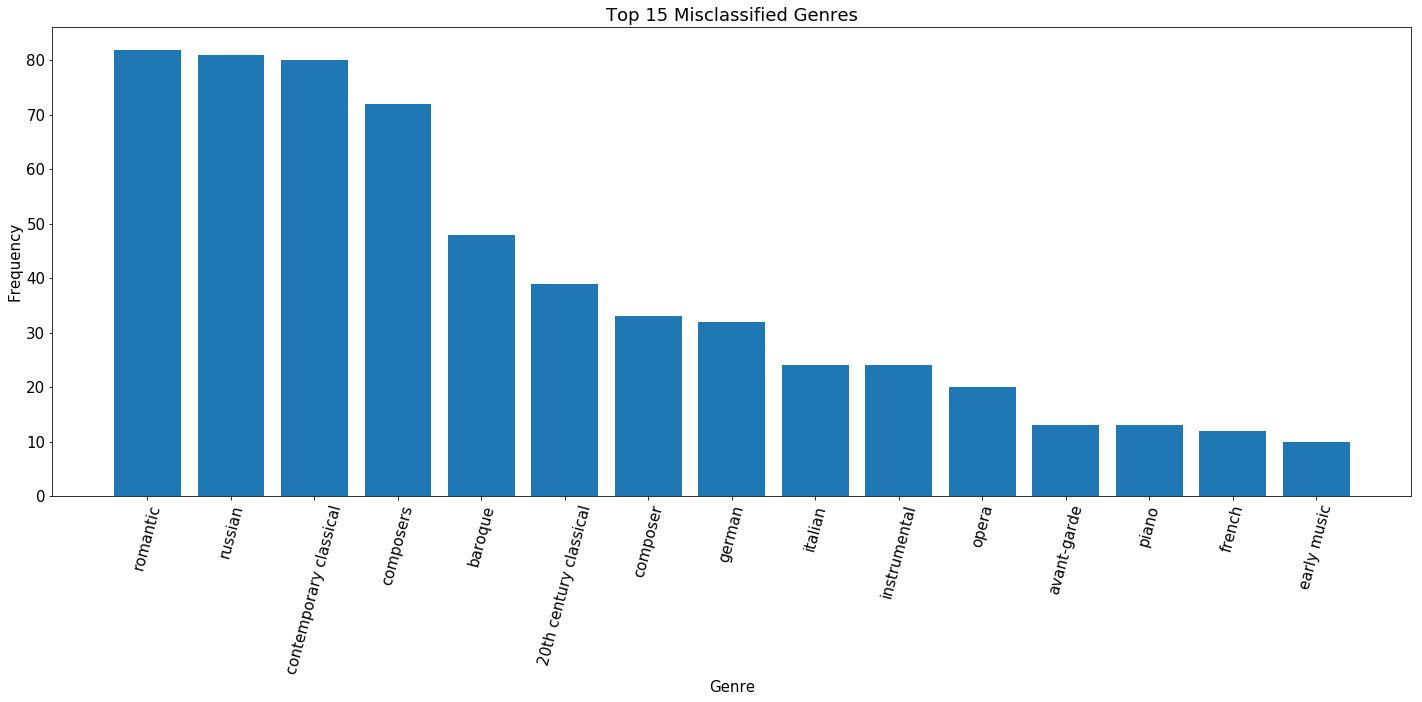

In [209]:
#plotting top 25 tags, not including 'classical', which is the 0th index
plt.rc('font', size=15)          # controls default text sizes

plt.figure(figsize=(20,10))
plt.bar({x: tag_count[x] for x in sorted(tag_count, key=tag_count.get, reverse=True)[1:16]}.keys(), {x: tag_count[x] for x in sorted(tag_count, key=tag_count.get, reverse=True)[1:16]}.values())
plt.xticks(rotation=75)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Top 15 Misclassified Genres')
plt.tight_layout()
plt.savefig('top_misclassified_genres', dpi=150)

Well that's weird, I kind of expected there to be a more clear kind of music it struggled with, but it sort of seems like it struggled with....everything? However, comtemporary classical, romantic, and 20th century classical sound like they could go either way (ballet or non ballet), so perhaps it speaks to that? I'll split up this data to see how ballets are misclassified and how non-ballets are misclassified.

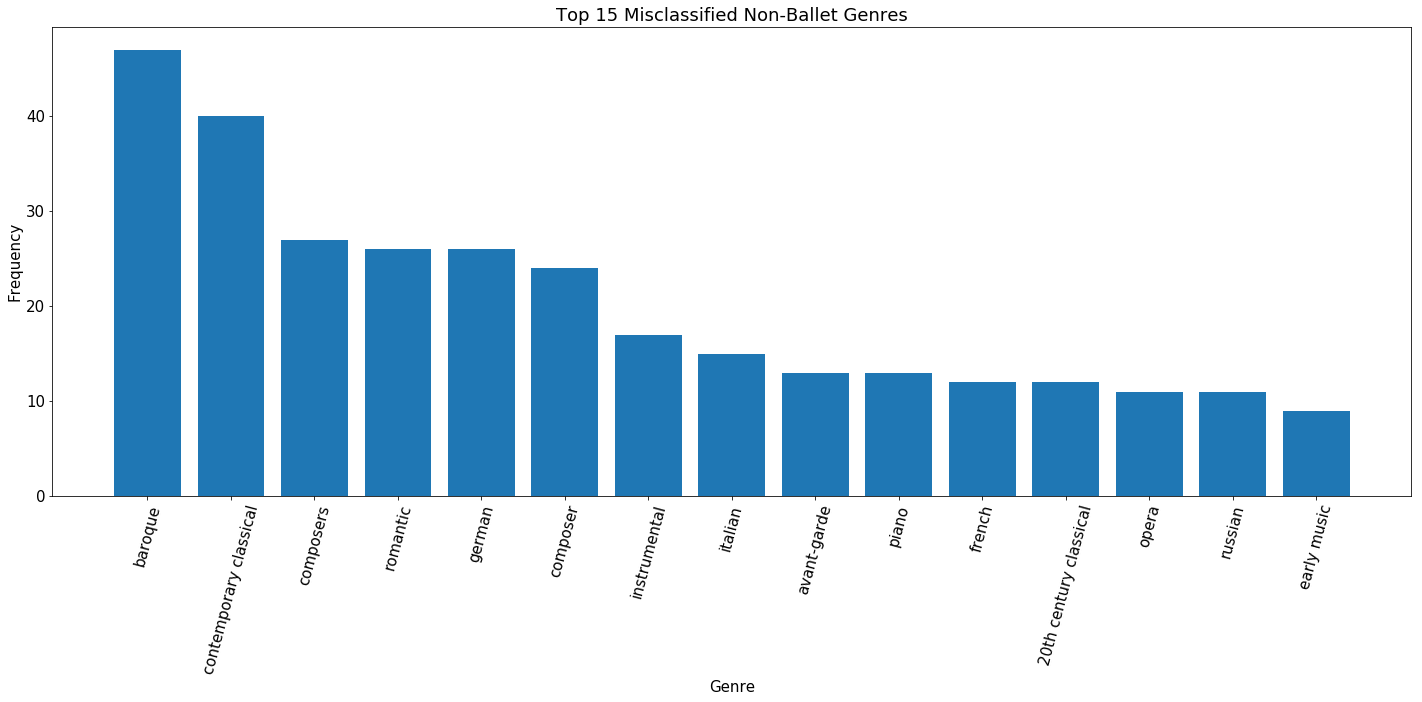

In [219]:
# get non-ballet misclassified tags
non_ballet_misclassified = [song_tags[song] for song in song_tags if data['ballet'][song[14:]] == 0]

non_ballet_tags = []
for x in non_ballet_misclassified:
    for y in x:
        non_ballet_tags.append(y)
        
nb_tag_count = {}
for genre in set(tags):
    nb_tag_count[genre] = non_ballet_tags.count(genre)
    
#plotting top 25 tags, not including 'classical', which is the 0th index
plt.rc('font', size=15)          # controls default text sizes

plt.figure(figsize=(20,10))
plt.bar({x: nb_tag_count[x] for x in sorted(nb_tag_count, key=nb_tag_count.get, reverse=True)[1:16]}.keys(), {x: nb_tag_count[x] for x in sorted(nb_tag_count, key=nb_tag_count.get, reverse=True)[1:16]}.values())
plt.xticks(rotation=75)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Top 15 Misclassified Non-Ballet Genres')
plt.tight_layout()
plt.savefig('top_nb_misclassified_genres', dpi=150)

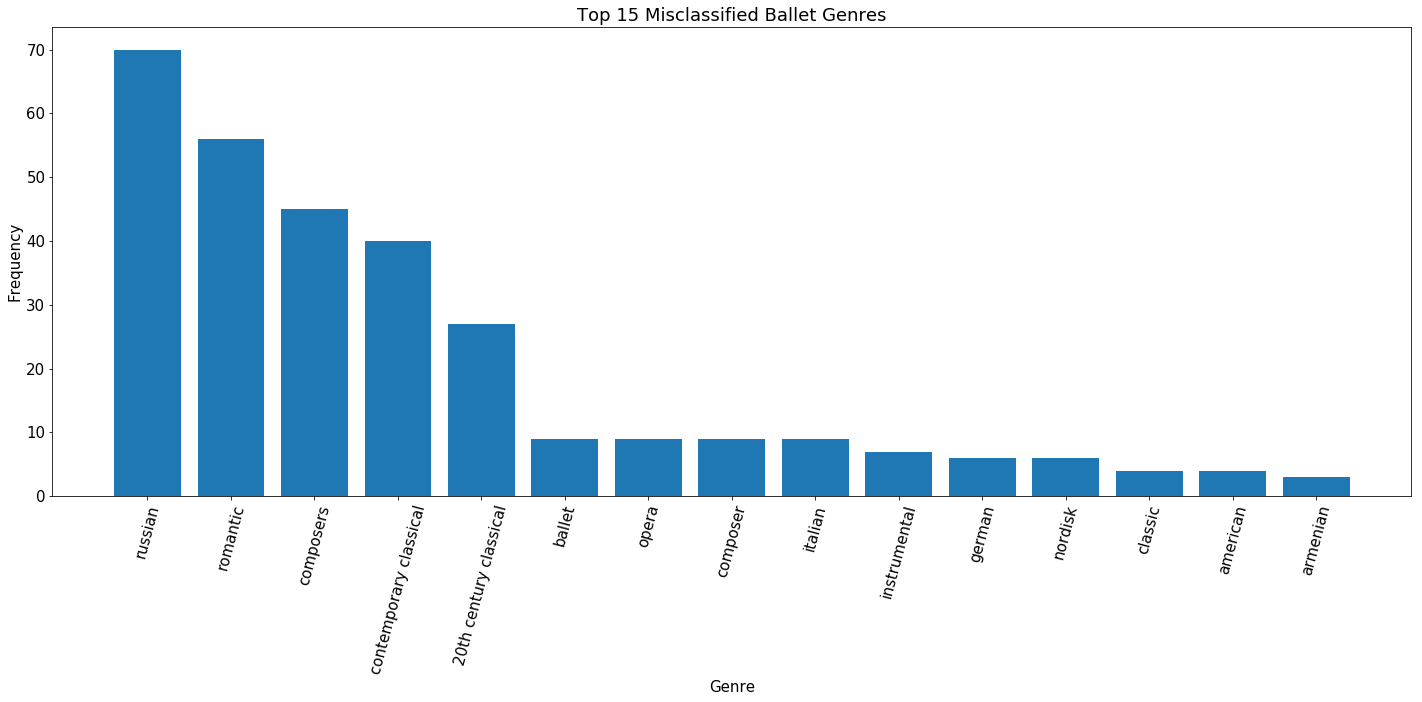

In [221]:
# get ballet misclassified tags
ballet_misclassified = [song_tags[song] for song in song_tags if data['ballet'][song[14:]] == 1]

ballet_tags = []
for x in ballet_misclassified:
    for y in x:
        ballet_tags.append(y)
        
b_tag_count = {}
for genre in set(tags):
    b_tag_count[genre] = ballet_tags.count(genre)
    
#plotting top 25 tags, not including 'classical', which is the 0th index
plt.rc('font', size=15)          # controls default text sizes

plt.figure(figsize=(20,10))
plt.bar({x: b_tag_count[x] for x in sorted(b_tag_count, key=b_tag_count.get, reverse=True)[1:16]}.keys(), {x: b_tag_count[x] for x in sorted(b_tag_count, key=b_tag_count.get, reverse=True)[1:16]}.values())
plt.xticks(rotation=75)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Top 15 Misclassified Ballet Genres')
plt.tight_layout()
plt.savefig('top_b_misclassified_genres', dpi=150)

## Predicting New Songs

In [180]:
# setting up spotify so we can get song info
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id=config.client_id, 
                                                          client_secret=
                                                          config.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 


def get_song_info(song_uri):
    y = sp.audio_analysis('spotify:track:3sqbu5KMlXNUokeVgnvNCO') #dummy info so analysis_df works
    feature_df = pd.DataFrame(sp.audio_features(song_uri))
    analysis_df = pd.DataFrame([sp.audio_analysis(song_uri),y])
    analysis_df.drop(1, inplace=True)
    return pd.concat([feature_df, analysis_df], axis=1)
    
def song_data(data):
    data['no_segments'] = data.apply(lambda x: len(x.segments), axis=1)
    data['no_sections'] = data.apply(lambda x: len(x.sections), axis=1)
    data['sec_duration_range'] = data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['seg_duration_range'] = data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['sec_loudness_range'] = data.apply(lambda x: max([y['loudness'] for y in x.sections]) - min([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['sec_key_range'] = data.apply(lambda x: max([y['key'] for y in x.sections]) - min([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['sec_tempo_range'] = data.apply(lambda x: max([y['tempo'] for y in x.sections]) - min([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['sec_mode_range'] = data.apply(lambda x: max([y['mode'] for y in x.sections]) - min([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['sec_time_signature_range'] = data.apply(lambda x: max([y['time_signature'] for y in x.sections]) - min([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
    data['no_unique_pitches'] = data.apply(lambda x: len(set(get_pitches(x.segments))), axis=1)
    data['no_unique_timbres'] = data.apply(lambda x: len(set(get_timbre_count(get_rounded_timbres(x.segments)))), axis=1)
    data['mean_pitch'] = data.apply(lambda x: np.mean(list(set(get_pitches(x.segments)))), axis=1)
    data.drop(['bars', 'beats', 'sections', 'segments', 'tatums', 'track'], axis=1, inplace=True)
    data.drop(['analysis_url', 'track_href', 'type', 'uri', 'meta','id'], axis=1, inplace=True)
    return data

def song_prediction(classifier, data):
    return classifier.predict(data)
    
#####################################
# helper functions for song_feature_engineering
def get_pitches(segment):
    pitches = []
    for x in segment:
        for y in x['pitches']:
            pitches.append(y)
    return pitches

def get_rounded_timbres(segment):
    timbres = []
    for x in segment:
        for y in x['timbre']:
            timbres.append(round(y))
    return timbres

def get_timbre_count(timbres):
    timbre_count = {}
    for timbre in set(timbres):
        timbre_count[timbre] = timbres.count(timbre)
    return timbre_count

def get_timbre_seg_avg(segment):
    avgs = []
    for seg in segment:
        avgs.append(np.mean(seg['timbre']))
    return np.mean(avgs)

def get_pitch_seg_avg(segment):
    avgs = []
    for seg in segment:
        avgs.append(np.mean(seg['pitches']))
    return np.mean(avgs)

In [181]:
song_prediction(forest, song_data(get_song_info('spotify:track:0hLjjlCHktvkU6GtOoU1Nk'))) # erev shel shoshanim

array([0])

In [182]:
song_prediction(forest, song_data(get_song_info('spotify:track:59pxmlKl59Fr5uU8CVKft3'))) # sleeping beauty

array([1])

In [185]:
song_prediction(forest, song_data(get_song_info('spotify:track:4dkoqJrP0L8FXftrMZongF'))) # across the universe

array([1])

In [186]:
song_prediction(forest, song_data(get_song_info('spotify:track:52dm9op3rbfAkc1LGXgipW'))) # wild horses 

array([0])

In [194]:
song_prediction(forest, song_data(get_song_info('spotify:track:23ryVoyGTrfO3F0GblIfnz'))) # Elgar: Variations on an Original Theme (non ballet that sounds like a ballet)

array([1])

In [193]:
song_prediction(forest, song_data(get_song_info('spotify:track:1Oui96x92JVAzK4nsoKavW'))) # River Free

array([0])

In [195]:
song_prediction(forest, song_data(get_song_info('spotify:track:14BlTiqA413Z6WRCG3FMao'))) # Little Martha

array([1])

In [196]:
song_prediction(forest, song_data(get_song_info('spotify:track:5JBUpI6OGZahUqchMKe6UY'))) # Whipping Post

array([0])

In [198]:
song_prediction(forest, song_data(get_song_info('spotify:track:2PzU4IB8Dr6mxV3lHuaG34'))) # (I can't get no) Satisfaction

array([0])

In [201]:
song_prediction(forest, song_data(get_song_info('spotify:track:5DQAHkO9U4IZIombHefcqK'))) # Peg

array([0])